# Drive Linking
Linking Google Drive to Colab to enable loading data from the cloud.

In [ ]:
from google.colab import drive                                                  # Import the Google Colab Drive module

drive.mount('/content/drive')                                                   # Base address of the drive

Mounted at /content/drive


# Library Import
Importing all necessary libraries and modules.

In [ ]:
# Modules for operating system and file management
import os                                                   # To interact with the operating system, manage files and directories
import shutil                                               # For high-level file operations, such as copying and removing files and directories
import sys                                                  # To access specific operating system features, such as command-line arguments and program exit

# Modules for time management and performance measurement
import time                                                 # For time management, useful for measuring performance and durations

# Modules for copying and random operations
import copy                                                 # To create shallow and deep copies of objects
import random                                               # To generate random numbers and perform operations related to randomness
from random import shuffle                                  # To shuffle elements in a list

# Modules for regular expression operations
import re                                                   # For operations with regular expressions

# Modules for scientific computation and data analysis
import scipy.io as sio                                      # For working with MATLAB files, especially for reading and writing .mat files
import pandas as pd                                         # For data manipulation and analysis, particularly useful for handling tabular datasets
import numpy as np                                          # For scientific computation, support for multidimensional arrays and mathematical functions

# Modules for data visualization
import matplotlib.pyplot as plt                             # For data visualization and plotting
from tqdm import tqdm                                       # For displaying progress bars for loops

# Modules for deep learning and computer vision with PyTorch
import torch                                                # Fundamental library for deep learning, support for tensors and GPU operations
import torch.nn as nn                                       # For building neural networks
import torch.optim as optim                                 # For various optimization algorithms
from torch.optim import lr_scheduler                        # For adjusting the learning rate during training
from torch.utils.data import DataLoader, Dataset            # For managing and loading datasets
from torchsummary import summary                            # To get a summary of PyTorch neural networks
import torchvision                                          # PyTorch library specific to computer vision, includes datasets, pretrained models, and data transformations
from torchvision import datasets, models, transforms       # torchvision modules for managing datasets, pretrained models, and data transformations

# Modules for dataset splitting
from sklearn.model_selection import StratifiedShuffleSplit  # To perform dataset splitting while maintaining class distribution

# Check Device
Checking the availability of Google GPUs.

In [ ]:
# Set the device for running the model on GPU if available, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Version: " + str(torch.__version__))
print("Avaible?: " + str(torch.cuda.is_available()))
print("Device: " + str(torch.cuda.get_device_name(0)))
print("Run GPU?: " + str(device))

Version: 2.3.0+cu121
Avaible?: True
Device: Tesla T4
Run GPU?: cuda:0


# Options
Setting the randomness in PyTorch and NumPy, ensuring reproducible results during training.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Path
Paths to content on Google Drive.

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset'
DATASET_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/dataset'
TRAIN_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/train'
VAL_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/val'
TEST_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/test'
CULTURE_PATH = '/content/drive/MyDrive/ML/Minicontest3/Dataset/culture'
WEIGHTS_PATH = '/content/drive/MyDrive/ML/Minicontest3/Weights'
FINAL_WEIGHTS_PATH = '/content/drive/MyDrive/ML/Minicontest3/Weights/Final_Weights'

# Bacterial Culture Search
Searching for bacterial culture images within the dataset. These images were identified due to their significantly larger sizes compared to other `.npy` files. The culture images are being removed as they are deemed to lack relevant informative content for neural network training.

In [ ]:
def move_large_files(base_path, destination_folder, size_threshold_mb=10):
    """
    Traverses through folders and moves files larger than size_threshold_mb to a new folder.

    Parameters:
    base_path (str): The path of the main folder.
    destination_folder (str): Path of the destination folder for large files.
    size_threshold_mb (int): The size in MB above which files are moved. Default is 10MB.
    """
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    size_threshold_bytes = size_threshold_mb * 1024 * 1024                      # Convert MB to bytes

    for root, dirs, files in os.walk(base_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)

            if file_size > size_threshold_bytes:
                # Create destination path
                relative_path = os.path.relpath(root, base_path)
                destination_path = os.path.join(destination_folder, relative_path)

                if not os.path.exists(destination_path):
                    os.makedirs(destination_path)

                # Move the file
                shutil.move(file_path, os.path.join(destination_path, file))
                print(f"Moved '{file_path}' to '{os.path.join(destination_path, file)}'")

In [ ]:
def display_images_from_folder(folder_path):
    """
    Displays all numpy images in a folder and its subfolders.

    Parameters:
    folder_path (str): The path of the folder containing numpy images.
    """
    # Numpy file extensions
    npy_extension = '.npy'

    # Iterate through all directories and subdirectories
    for root, _, files in os.walk(folder_path):
        # Filter files for numpy extension
        npy_files = [f for f in files if f.lower().endswith(npy_extension)]

        # Display each numpy file
        for npy_file in npy_files:
            npy_path = os.path.join(root, npy_file)
            try:
                image = np.load(npy_path)                                       # Load the numpy file
                plt.imshow(image)
                plt.title(npy_file)
                plt.axis('off')                                                 # Disable axes
                plt.show()
            except Exception as e:
                print(f"Error opening {npy_file} in {root}: {e}")

In [ ]:
move_large_files(DATASET_PATH, CULTURE_PATH)
display_images_from_folder(CULTURE_PATH)

# Data Exploration
Visualization of various dataset data, useful for subsequent sections and to identify the best splitting. Particularly, the presence of imbalance between the two classes, benign and malignant, has also been analyzed.

In [ ]:
def count_dir_elements(path):
    """
    Counts the number of elements (files and directories) in each subfolder of a specified directory.

    Parameters:
    path (str): The path of the main directory.

    Returns:
    dict: A dictionary with subfolder paths as keys and the number of elements in each subfolder as values.
    """
    elements_in_dir = {}
    for root, dirs, files in os.walk(path):
        if root == path:
            continue                                                            # Skip the main directory
        n_elements = len(dirs) + len(files)
        elements_in_dir[root] = n_elements
    return elements_in_dir

In [ ]:
def build_element_matrix(base_path):
    """
    Builds a matrix representing the number of elements in the first 40 subfolders of the 'benign' and 'malignant' categories.

    Parameters:
    base_path (str): The path of the main directory.

    Returns:
    tuple: A matrix with the number of elements in the subfolders and a list of subfolder paths.
    """
    dirs = ['benign', 'malignant']
    n_columns = 40
    matrix = np.zeros((2, n_columns), dtype=int)

    for i, dir_name in enumerate(dirs):
        current_path = os.path.join(base_path, dir_name)
        elements_in_dir = count_dir_elements(current_path)
        sub_dirs = list(elements_in_dir.keys())[:n_columns]

        for j, sub_dir in enumerate(sub_dirs):
            matrix[i, j] = elements_in_dir[sub_dir]

    return matrix

In [ ]:
# Build the result matrix and get the subfolder paths
result_matrix = build_element_matrix(DATASET_PATH)

m, n = result_matrix.shape
total_elements = np.sum(result_matrix)
num_benign = np.sum(result_matrix[0, :])
num_malignant = np.sum(result_matrix[1, :])
ratio = num_benign / num_malignant

print("Total elements:", total_elements)
print("Number of benign:", num_benign)
print("Number of malignant:", num_malignant)
print("Benign/Malignant Ratio:", ratio)

# Print the matrix accounting for elements for each culture
first_time = True
for idx, row in enumerate(result_matrix):
    if first_time:
        print("Number of elements for each benign culture:")
        first_time = False
    else:
        print("Number of elements for each malignant culture:")
    print(" [", end="")
    print(", ".join(map(str, row)), end="")
    print("]")

Elementi totali: 4910
Numero di benigne: 1291
Numero di maligne: 3619
Ratio Benigne/Maligne: 0.35672837800497376
Numero di elementi per ogni coltura benigna:
 [27, 19, 24, 34, 23, 31, 34, 21, 23, 37, 25, 21, 35, 19, 40, 28, 26, 27, 50, 30, 20, 27, 57, 29, 58, 65, 42, 29, 18, 62, 27, 29, 79, 35, 24, 28, 34, 15, 24, 15]
Numero di elementi per ogni coltura maligna:
 [128, 83, 65, 71, 75, 98, 94, 109, 83, 94, 87, 105, 97, 101, 74, 110, 77, 73, 79, 83, 109, 90, 92, 75, 86, 104, 88, 83, 97, 93, 85, 87, 115, 86, 90, 87, 100, 71, 115, 80]


# Data Visualization
Visualizing various `.npy` files to explore the data present in the dataset.

In [ ]:
def list_npy_files(folder_path):
    """
    Lists .npy files in a folder and its subfolders.

    Parameters:
    folder_path (str): The path of the folder to examine.

    Returns:
    list: A list of full paths of found .npy files.
    """
    npy_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    return npy_files

In [ ]:
def display_images(npy_files, num_images_to_show=100, reverse_order=False):
    """
    Displays numpy images with separated channels and the file name.

    Parameters:
    npy_files (list): List of paths of .npy files.
    num_images_to_show (int): Number of images to display.
    reverse_order (bool): If True, sorts the files in reverse alphabetical order.
    """
    if reverse_order:
        npy_files.sort(reverse=True)
    else:
        npy_files.sort()

    num_images_to_show = min(num_images_to_show, len(npy_files))                # Ensure not to exceed the available file count

    plt.figure(figsize=(10, 2 * num_images_to_show))
    channel_titles = ['Channel 1', 'Channel 2', 'Channel 3', 'Original Image']  # Channel labels

    for i in range(num_images_to_show):
        image = np.load(npy_files[i])                                           # Load the numpy image
        channels = [image[:, :, 0], image[:, :, 1], image[:, :, 2], image]      # Split the image into its channels

        for j, channel in enumerate(channels):
            plt.subplot(num_images_to_show, 4, 4 * i + j + 1)
            plt.imshow(channel, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(channel_titles[j])

        plt.subplot(num_images_to_show, 4, 4 * i + 4)
        plt.title(os.path.basename(npy_files[i]), fontsize=8)                   # Add file name as title of the last channel
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Parameters
NUM_IMAGES_TO_SHOW = 15
REVERSE_ORDER = False

npy_files = list_npy_files(TEST_PATH)                                           # Get the list of .npy files

if not npy_files:
    print("No .npy files found in the specified directory.")
else:
    display_images(npy_files, NUM_IMAGES_TO_SHOW, REVERSE_ORDER)

No .npy files found in the specified directory.


# Stratified Splitting
Managing and organizing directories for training and validation. Using the `StratifiedShuffleSplit` function to split the dataset in a stratified manner, ensuring a balanced distribution of classes. These functions ensure that the dataset is divided efficiently and balanced, optimizing data preparation for training and validation.

In [ ]:
def split_dataset(dataset_path, destination_path, val_ratio=0.2, seed=42):
    """
    Splits a dataset into training and validation sets, preserving the directory structure.

    Parameters:
    - dataset_path (str): The path to the directory containing the dataset.
    - destination_path (str): The path to the directory where the split dataset will be saved.
    - val_ratio (float): The ratio of validation data to total data. Default is 0.2.
    - seed (int): The seed for random number generation to ensure reproducibility. Default is 42.

    Returns:
    None
    """
    # Set seed for reproducibility
    random.seed(seed)

    # Paths of destination folders
    train_dir = os.path.join(destination_path, 'train')
    val_dir = os.path.join(destination_path, 'val')

    # Function to clean and recreate destination directories
    def reset_directory(directory):
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)

    # Clean destination directories
    reset_directory(train_dir)
    reset_directory(val_dir)

    # List of files in the dataset, including subfolders
    files = []
    labels = []
    for root, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
            # Assume classes are represented by subfolders
            labels.append(os.path.basename(root))

    # Use StratifiedShuffleSplit to stratify split the files
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=seed)
    train_indices, val_indices = next(strat_split.split(files, labels))

    train_files = [files[i] for i in train_indices]
    val_files = [files[i] for i in val_indices]

    # Function to copy files to destination folders while maintaining subfolder structure
    def copy_files(file_list, dest_dir):
        for file in tqdm(file_list, desc=f"Copying files to {dest_dir}"):
            rel_path = os.path.relpath(file, dataset_path)
            dest_path = os.path.join(dest_dir, rel_path)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.copy2(file, dest_path)

    # Copy files to destination folders
    print("Copying files to 'train' folder:")
    copy_files(train_files, train_dir)

    print("Copying files to 'val' folder:")
    copy_files(val_files, val_dir)

    print(f"Dataset split: {len(train_files)} files in 'train', {len(val_files)} files in 'val'")

In [ ]:
split_dataset(DATASET_PATH, DATA_PATH, val_ratio=0.25, seed=42)

Copia dei file nella cartella 'train':


Copying files to /content/drive/MyDrive/ML/Minicontest3/Dataset/train: 100%|██████████| 3682/3682 [17:52<00:00,  3.43it/s]


Copia dei file nella cartella 'val':


Copying files to /content/drive/MyDrive/ML/Minicontest3/Dataset/val: 100%|██████████| 1228/1228 [05:56<00:00,  3.44it/s]

Dataset suddiviso: 3682 file in 'train', 1228 file in 'val'


# Transformations and Data Loader (Train and Validation)
Defining data transformations and loaders for the training and validation sets. Setting the batch size and defining the custom class `My_DatasetFolder`, which handles reading files, applying transformations, and splitting images into their respective classes (benign and malignant). Transformations for the training set include operations such as converting to tensors, padding, resizing, horizontal and vertical flipping, random rotation, and normalization. For the validation set, transformations include converting to tensors, resizing, and normalization. Training and validation datasets are then created using `My_DatasetFolder`, and DataLoader is set up to load data in batches, enabling shuffling and using multiple processes for efficient loading.

In [ ]:
# Definition of the My_DatasetFolder class
class My_DatasetFolder(Dataset):
    def __init__(self, root, transform, is_valid_file, list_classes):
        self.root = root
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.list_classes = list_classes
        self.samples = self.__get_samples()

    def __len__(self):
        return len(self.samples)

    def __get_samples(self):
        # Initialize an empty list to store file paths and their corresponding labels
        ListFiles = []
        # Iterate through each class in the list of classes
        for c in self.list_classes:
            # Get the list of folders in the current class directory
            list_folder = os.listdir(os.path.join(self.root, c))
            # Iterate through each folder in the current class directory
            for folder in list_folder:
                # Get the list of files in the current folder
                listofFiles = os.listdir(os.path.join(self.root, c, folder))
                # Iterate through each file in the current folder
                for file in listofFiles:
                    # Check if the file is valid
                    if self.is_valid_file(os.path.join(self.root, c, folder, file)):
                        # Append the file path and its corresponding label index to the list
                        ListFiles.append((os.path.join(self.root, c, folder, file), self.list_classes.index(c)))
        return ListFiles

    def loader_fc(self, path):
        # Load image from numpy file
        img = np.load(path)
        return img

    def __getitem__(self, index: int):
        # Get the file path and its corresponding label at the given index
        path, target = self.samples[index]
        # Load the sample using the loader function
        sample = self.loader_fc(path)
        # Apply transformation if specified
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(3, padding_mode='edge'),                                 # Adds a padding of 3 pixels on the edges
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),                                      # Adds horizontal flip
        transforms.RandomVerticalFlip(),                                        # Adds vertical flip
        transforms.RandomRotation(degrees=10),                                  # Adds random rotation
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
is_valid_file = lambda path: path.endswith('.npy')
batch_size = 32

# Creation of training and validation datasets using My_DatasetFolder
train_dataset = My_DatasetFolder(root=TRAIN_PATH, transform=data_transforms['train'], is_valid_file=is_valid_file, list_classes=['benign', 'malignant'])
val_dataset = My_DatasetFolder(root=VAL_PATH, transform=data_transforms['val'], is_valid_file=is_valid_file, list_classes=['benign', 'malignant'])

# Creation of DataLoader for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# Print the size of training and validation datasets
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)
print("Training dataset size:", train_dataset_size)
print("Validation dataset size:", val_dataset_size)

Dimensione del dataset di addestramento: 3682
Dimensione del dataset di validazione: 1228


# Training with Validation
Defining a training and validation loop based on the pre-trained ResNet50 network. Training the model is performed over a specified number of epochs, updating the model weights and saving the best weights obtained during training.
The training loop involves cleaning existing log files and training the model for each epoch, calculating loss and accuracy on each batch of the training and validation dataloaders.
At the end of each epoch, training and validation results are recorded, and if the validation accuracy improves, the model weights are saved.
The ResNet50 model is modified for binary classification, freezing initial layers and updating only the final layers during training. The loss function used is `BCEWithLogitsLoss`, and the optimizer is Adam.

In [ ]:
def train_loop_validation(train_dataloader, val_dataloader, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv, best_acc, best_loss, best_epoca, outputPath, scheduler=None):
    """
    Trains a convolutional neural network model using the given data loaders for training and validation.

    Parameters:
    - train_dataloader (DataLoader): DataLoader for training dataset.
    - val_dataloader (DataLoader): DataLoader for validation dataset.
    - startEpoch (int): Starting epoch number.
    - numEpochs (int): Total number of epochs for training.
    - model_conv (torch.nn.Module): The convolutional neural network model.
    - criterionCNN (torch.nn.Module): The loss function.
    - optimizer_conv (torch.optim.Optimizer): The optimizer.
    - best_acc (float): The best accuracy achieved during training.
    - best_loss (float): The best loss achieved during training.
    - best_epoca (int): The epoch number with the best performance.
    - outputPath (str): The directory path to save the trained model and logs.
    - scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Default is None.

    Returns:
    int: The epoch number with the best performance.
    """

    # Clear existing text files, if any
    train_files = ['lossTrain.txt', 'AccTrain.txt', 'lossVal.txt', 'AccVal.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for inputs, labels in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            inputs = inputs.float().to(device)
            labels = labels.view(-1, 1).float().to(device)                      # Convert labels to float and reshape

            optimizer_conv.zero_grad()
            outputs = model_conv(inputs)
            lossCNN = criterionCNN(outputs, labels)
            lossCNN.backward()
            optimizer_conv.step()

            modelLoss_train += lossCNN.item() * inputs.size(0)
            totalSize += inputs.size(0)

            # Apply sigmoid to outputs and round to get binary predictions
            preds = torch.sigmoid(outputs).round()
            modelAcc_train += torch.sum(preds == labels.data).item()

        modelLoss_epoch_train = modelLoss_train / totalSize
        modelAcc_epoch_train = modelAcc_train / totalSize

        # Validation loop
        model_conv.eval()
        totalSize_val = 0
        modelLoss_val = 0.0
        modelAcc_val = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Validation"):
                inputs = inputs.float().to(device)
                labels = labels.view(-1, 1).float().to(device)                  # Convert labels to float and reshape

                outputs = model_conv(inputs)
                lossCNN = criterionCNN(outputs, labels)

                modelLoss_val += lossCNN.item() * inputs.size(0)
                totalSize_val += inputs.size(0)

                preds = torch.sigmoid(outputs).round()
                modelAcc_val += torch.sum(preds == labels.data).item()

        modelLoss_epoch_val = modelLoss_val / totalSize_val
        modelAcc_epoch_val = modelAcc_val / totalSize_val
        time_elapsed = time.time() - since

        current_lr = optimizer_conv.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val,
                 modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Save the best model
        if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss):
            print('     .... Saving best weights ....')
            best_acc = modelAcc_epoch_val
            best_loss = modelLoss_epoch_val
            best_epoch = epoch
            torch.save(model_conv.state_dict(), os.path.join(outputPath, 'best_model_weights.pth'))

        # Scheduler step
        if scheduler:
            scheduler.step(modelLoss_epoch_val)

        # Logging losses and accuracies
        with open(os.path.join(outputPath, 'lossTrain.txt'), "a") as file_object:
            file_object.write(str(modelLoss_epoch_train) + '\n')

        with open(os.path.join(outputPath, 'AccTrain.txt'), "a") as file_object:
            file_object.write(str(modelAcc_epoch_train) + '\n')

        with open(os.path.join(outputPath, 'lossVal.txt'), "a") as file_object:
            file_object.write(str(modelLoss_epoch_val) + '\n')

        with open(os.path.join(outputPath, 'AccVal.txt'), "a") as file_object:
            file_object.write(str(modelAcc_epoch_val) + '\n')

        sio.savemat(os.path.join(outputPath, 'check_point.mat'), {'best_acc': best_acc,
                                                                  'best_loss': best_loss,
                                                                  'best_epoca': best_epoca,
                                                                  'last_epoch': epoch})

    # Return the best epoch
    return best_epoch

In [ ]:
# Define the model
model_conv = models.resnet50(pretrained=True).cuda()

# Print the model summary
summary(model_conv, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Updated hyperparameters
learning_rate = 0.001                                                           # Learning rate for the optimizer
num_epochs = 50                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

# Redefine the model to avoid overwriting
model_conv = models.resnet50(pretrained=True).cuda()  # Load the pretrained ResNet50 model and move it to GPU

# Replace the last layer for binary classification
num_ftrs = model_conv.fc.in_features                                            # Number of output features from the penultimate layer
model_conv.fc = nn.Linear(num_ftrs, 1).cuda()                                   # Replace the last layer with an fc layer for binary classification

# Freeze only the parameters of the early blocks of the model
for name, param in model_conv.named_parameters():
    if 'layer4' not in name and 'fc' not in name:                               # Freeze parameters of all layers except 'layer4' and 'fc'
        param.requires_grad = False

# Define criterion and optimizer
criterionCNN = nn.BCEWithLogitsLoss().cuda()                                                                                  # Define the loss function for binary classification
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=learning_rate)

In [ ]:
# Call the training function with validation
best_epoch = train_loop_validation(train_dataloader, val_dataloader, startEpoch, num_epochs, model_conv, criterionCNN, optimizer_conv, best_acc, best_loss, best_epoch, WEIGHTS_PATH)

Epoch 1/50 - Validation: 100%|██████████| 39/39 [08:39<00:00, 13.32s/it]


[Epoch 1][TRAIN on 3682 [Loss: 0.3173  ACC: 0.8772]][VAL on 1228 [Loss: 0.2934  ACC: 0.9055]][TIME: 34 m 15 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 2/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.00it/s]


[Epoch 2][TRAIN on 3682 [Loss: 0.2217  ACC: 0.9109]][VAL on 1228 [Loss: 0.2498  ACC: 0.9031]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 3/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.01it/s]


[Epoch 3][TRAIN on 3682 [Loss: 0.1864  ACC: 0.9275]][VAL on 1228 [Loss: 0.1968  ACC: 0.9259]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 4/50 - Validation: 100%|██████████| 39/39 [00:10<00:00,  3.71it/s]


[Epoch 4][TRAIN on 3682 [Loss: 0.1989  ACC: 0.9240]][VAL on 1228 [Loss: 0.2448  ACC: 0.9251]][TIME: 0 m 50 s] [LR: 0.00100]


Epoch 5/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


[Epoch 5][TRAIN on 3682 [Loss: 0.1787  ACC: 0.9297]][VAL on 1228 [Loss: 0.1990  ACC: 0.9267]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 6/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.20it/s]


[Epoch 6][TRAIN on 3682 [Loss: 0.1578  ACC: 0.9392]][VAL on 1228 [Loss: 0.2189  ACC: 0.9259]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 7/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.21it/s]


[Epoch 7][TRAIN on 3682 [Loss: 0.1470  ACC: 0.9419]][VAL on 1228 [Loss: 0.1851  ACC: 0.9300]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 8/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.08it/s]


[Epoch 8][TRAIN on 3682 [Loss: 0.1197  ACC: 0.9527]][VAL on 1228 [Loss: 0.2113  ACC: 0.9202]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 9/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.13it/s]


[Epoch 9][TRAIN on 3682 [Loss: 0.1224  ACC: 0.9552]][VAL on 1228 [Loss: 0.2140  ACC: 0.9349]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 10/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23it/s]


[Epoch 10][TRAIN on 3682 [Loss: 0.0968  ACC: 0.9631]][VAL on 1228 [Loss: 0.2872  ACC: 0.8998]][TIME: 0 m 49 s] [LR: 0.00100]


Epoch 11/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.08it/s]


[Epoch 11][TRAIN on 3682 [Loss: 0.1185  ACC: 0.9530]][VAL on 1228 [Loss: 0.2111  ACC: 0.9365]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 12/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.37it/s]


[Epoch 12][TRAIN on 3682 [Loss: 0.1197  ACC: 0.9557]][VAL on 1228 [Loss: 0.2640  ACC: 0.9275]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 13/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


[Epoch 13][TRAIN on 3682 [Loss: 0.0872  ACC: 0.9671]][VAL on 1228 [Loss: 0.1866  ACC: 0.9308]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 14/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.83it/s]


[Epoch 14][TRAIN on 3682 [Loss: 0.0965  ACC: 0.9636]][VAL on 1228 [Loss: 0.1830  ACC: 0.9365]][TIME: 0 m 48 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 15/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.12it/s]


[Epoch 15][TRAIN on 3682 [Loss: 0.0928  ACC: 0.9644]][VAL on 1228 [Loss: 0.1816  ACC: 0.9332]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 16/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


[Epoch 16][TRAIN on 3682 [Loss: 0.0691  ACC: 0.9761]][VAL on 1228 [Loss: 0.2110  ACC: 0.9308]][TIME: 0 m 51 s] [LR: 0.00100]


Epoch 17/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.18it/s]


[Epoch 17][TRAIN on 3682 [Loss: 0.0729  ACC: 0.9734]][VAL on 1228 [Loss: 0.1735  ACC: 0.9414]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 18/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22it/s]


[Epoch 18][TRAIN on 3682 [Loss: 0.0584  ACC: 0.9772]][VAL on 1228 [Loss: 0.2311  ACC: 0.9406]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 19/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.10it/s]


[Epoch 19][TRAIN on 3682 [Loss: 0.0624  ACC: 0.9750]][VAL on 1228 [Loss: 0.2288  ACC: 0.9365]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 20/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.18it/s]


[Epoch 20][TRAIN on 3682 [Loss: 0.1090  ACC: 0.9606]][VAL on 1228 [Loss: 0.1913  ACC: 0.9259]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 21/50 - Validation: 100%|██████████| 39/39 [00:10<00:00,  3.67it/s]


[Epoch 21][TRAIN on 3682 [Loss: 0.0744  ACC: 0.9720]][VAL on 1228 [Loss: 0.2061  ACC: 0.9438]][TIME: 0 m 49 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 22/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.20it/s]


[Epoch 22][TRAIN on 3682 [Loss: 0.0564  ACC: 0.9777]][VAL on 1228 [Loss: 0.2562  ACC: 0.9414]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 23/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s]


[Epoch 23][TRAIN on 3682 [Loss: 0.0445  ACC: 0.9834]][VAL on 1228 [Loss: 0.2076  ACC: 0.9414]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 24/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.66it/s]


[Epoch 24][TRAIN on 3682 [Loss: 0.0633  ACC: 0.9756]][VAL on 1228 [Loss: 0.2477  ACC: 0.9121]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 25/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.09it/s]


[Epoch 25][TRAIN on 3682 [Loss: 0.0509  ACC: 0.9818]][VAL on 1228 [Loss: 0.2179  ACC: 0.9381]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 26/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.34it/s]


[Epoch 26][TRAIN on 3682 [Loss: 0.0441  ACC: 0.9832]][VAL on 1228 [Loss: 0.2234  ACC: 0.9471]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 27/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.18it/s]


[Epoch 27][TRAIN on 3682 [Loss: 0.0454  ACC: 0.9840]][VAL on 1228 [Loss: 0.2229  ACC: 0.9357]][TIME: 0 m 49 s] [LR: 0.00100]


Epoch 28/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  4.97it/s]


[Epoch 28][TRAIN on 3682 [Loss: 0.0924  ACC: 0.9677]][VAL on 1228 [Loss: 0.1916  ACC: 0.9406]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 29/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.83it/s]


[Epoch 29][TRAIN on 3682 [Loss: 0.0515  ACC: 0.9815]][VAL on 1228 [Loss: 0.2285  ACC: 0.9422]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 30/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.63it/s]


[Epoch 30][TRAIN on 3682 [Loss: 0.0428  ACC: 0.9823]][VAL on 1228 [Loss: 0.2408  ACC: 0.9422]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 31/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.76it/s]


[Epoch 31][TRAIN on 3682 [Loss: 0.0451  ACC: 0.9821]][VAL on 1228 [Loss: 0.4052  ACC: 0.9308]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 32/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.36it/s]


[Epoch 32][TRAIN on 3682 [Loss: 0.0668  ACC: 0.9734]][VAL on 1228 [Loss: 0.1771  ACC: 0.9454]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 33/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.41it/s]


[Epoch 33][TRAIN on 3682 [Loss: 0.0402  ACC: 0.9853]][VAL on 1228 [Loss: 0.3309  ACC: 0.9104]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 34/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.06it/s]


[Epoch 34][TRAIN on 3682 [Loss: 0.0665  ACC: 0.9750]][VAL on 1228 [Loss: 0.1778  ACC: 0.9528]][TIME: 0 m 47 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 35/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.10it/s]


[Epoch 35][TRAIN on 3682 [Loss: 0.0431  ACC: 0.9848]][VAL on 1228 [Loss: 0.2191  ACC: 0.9406]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 36/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.16it/s]


[Epoch 36][TRAIN on 3682 [Loss: 0.0387  ACC: 0.9859]][VAL on 1228 [Loss: 0.3244  ACC: 0.9275]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 37/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23it/s]


[Epoch 37][TRAIN on 3682 [Loss: 0.0288  ACC: 0.9889]][VAL on 1228 [Loss: 0.2246  ACC: 0.9397]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 38/50 - Validation: 100%|██████████| 39/39 [00:11<00:00,  3.48it/s]


[Epoch 38][TRAIN on 3682 [Loss: 0.0248  ACC: 0.9924]][VAL on 1228 [Loss: 0.2318  ACC: 0.9544]][TIME: 0 m 49 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 39/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.11it/s]


[Epoch 39][TRAIN on 3682 [Loss: 0.0530  ACC: 0.9796]][VAL on 1228 [Loss: 0.2719  ACC: 0.9332]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 40/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.16it/s]


[Epoch 40][TRAIN on 3682 [Loss: 0.0392  ACC: 0.9867]][VAL on 1228 [Loss: 0.2837  ACC: 0.9137]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 41/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s]


[Epoch 41][TRAIN on 3682 [Loss: 0.0956  ACC: 0.9641]][VAL on 1228 [Loss: 0.2061  ACC: 0.9414]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 42/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s]


[Epoch 42][TRAIN on 3682 [Loss: 0.0478  ACC: 0.9810]][VAL on 1228 [Loss: 0.1905  ACC: 0.9446]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 43/50 - Validation: 100%|██████████| 39/39 [00:09<00:00,  4.21it/s]


[Epoch 43][TRAIN on 3682 [Loss: 0.0405  ACC: 0.9851]][VAL on 1228 [Loss: 0.2125  ACC: 0.9422]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 44/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.79it/s]


[Epoch 44][TRAIN on 3682 [Loss: 0.0265  ACC: 0.9910]][VAL on 1228 [Loss: 0.1902  ACC: 0.9471]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 45/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.13it/s]


[Epoch 45][TRAIN on 3682 [Loss: 0.0298  ACC: 0.9886]][VAL on 1228 [Loss: 0.2236  ACC: 0.9503]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 46/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.20it/s]


[Epoch 46][TRAIN on 3682 [Loss: 0.0308  ACC: 0.9894]][VAL on 1228 [Loss: 0.2179  ACC: 0.9357]][TIME: 0 m 47 s] [LR: 0.00100]


Epoch 47/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.26it/s]


[Epoch 47][TRAIN on 3682 [Loss: 0.0372  ACC: 0.9872]][VAL on 1228 [Loss: 0.1902  ACC: 0.9422]][TIME: 0 m 46 s] [LR: 0.00100]


Epoch 48/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.13it/s]


[Epoch 48][TRAIN on 3682 [Loss: 0.0261  ACC: 0.9910]][VAL on 1228 [Loss: 0.2935  ACC: 0.9104]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 49/50 - Validation: 100%|██████████| 39/39 [00:07<00:00,  5.15it/s]


[Epoch 49][TRAIN on 3682 [Loss: 0.0892  ACC: 0.9661]][VAL on 1228 [Loss: 0.1480  ACC: 0.9536]][TIME: 0 m 48 s] [LR: 0.00100]


Epoch 50/50 - Validation: 100%|██████████| 39/39 [00:08<00:00,  4.61it/s]

[Epoch 50][TRAIN on 3682 [Loss: 0.0338  ACC: 0.9867]][VAL on 1228 [Loss: 0.2047  ACC: 0.9389]][TIME: 0 m 50 s] [LR: 0.00100]


# Metrics Plot
Visualization and analysis of performance metrics obtained during the training and validation process.
Loss and accuracy values are read from previously saved text files, and the values are plotted in two separate graphs: one for loss and the other for accuracy. This section allows for the selection of hyperparameters for the subsequent final training.

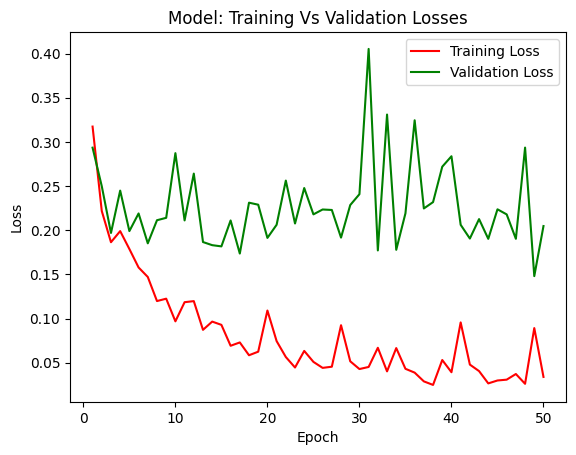

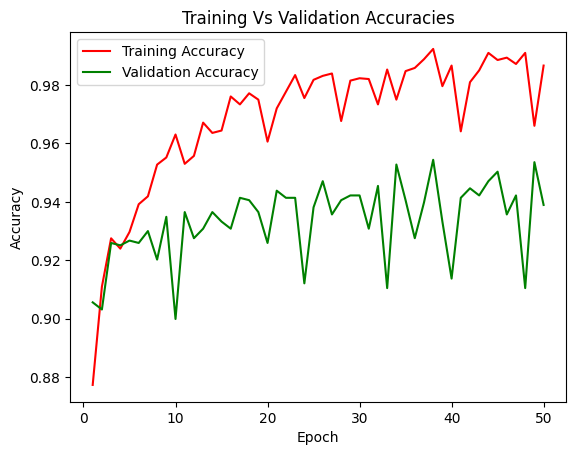

In [ ]:
# Initialization of lists for losses and accuracies
loss_model_train = []
loss_model_val = []
acc_model_train = []
acc_model_val = []

# Reading training loss files
loss_train_path = os.path.join(WEIGHTS_PATH, 'lossTrain.txt')
with open(loss_train_path, 'r') as file:
    loss_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation loss files
loss_val_path = os.path.join(WEIGHTS_PATH, 'lossVal.txt')
with open(loss_val_path, 'r') as file:
    loss_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation losses
plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(loss_model_train) + 1), loss_model_train, color='r', label="Training Loss")
plt.plot(range(1, len(loss_model_val) + 1), loss_model_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'LossTrainVal.png'))

# Reading training accuracy files
acc_train_path = os.path.join(WEIGHTS_PATH, 'AccTrain.txt')
with open(acc_train_path, 'r') as file:
    acc_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation accuracy files
acc_val_path = os.path.join(WEIGHTS_PATH, 'AccVal.txt')
with open(acc_val_path, 'r') as file:
    acc_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation accuracies
plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(acc_model_train) + 1), acc_model_train, color='r', label="Training Accuracy")
plt.plot(range(1, len(acc_model_val) + 1), acc_model_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'AccTrainVal.png'))

# Transformations and DataLoader (Full Dataset)
Applying previously defined transformations to the entire dataset without splitting into train and validation.

In [ ]:
# Lambda function to check if the file ends with '.npy'
is_valid_file = lambda path: path.endswith('.npy')

# Creating the final dataset for training using My_DatasetFolder
final_dataset = My_DatasetFolder(root=DATASET_PATH, transform=data_transforms['train'], is_valid_file=is_valid_file, list_classes=['benign', 'malignant'])

# Creating the final DataLoader for training
final_dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
# Printing the size of the dataset
final_dataset_size = len(final_dataset)
print("Dataset size:", final_dataset_size)

Dimensione del dataset: 4910


# Training (Full Dataset)
Training using the entire available dataset. During training, model loss and accuracy metrics are calculated and monitored. Additionally, model weights are saved after each epoch to allow for resumption and monitoring of training in case of interruptions.

In [ ]:
def train_loop(train_dataloader, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv, outputPath, scheduler=None):
    """
    Trains a convolutional neural network model using the given data loader for training.

    Parameters:
    - train_dataloader (DataLoader): DataLoader for the training dataset.
    - startEpoch (int): Starting epoch number.
    - numEpochs (int): Total number of epochs for training.
    - model_conv (torch.nn.Module): The convolutional neural network model.
    - criterionCNN (torch.nn.Module): The loss function.
    - optimizer_conv (torch.optim.Optimizer): The optimizer.
    - outputPath (str): The directory path to save the trained model and logs.
    - scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Default is None.

    Returns:
    None
    """

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Total number of batches
        total_batches = len(train_dataloader)

        # Training loop
        for batch_idx, (inputs, labels) in enumerate(tqdm(train_dataloader, total=total_batches)):
            inputs = inputs.float().cuda()
            labels = labels.view(-1, 1).float().cuda()                          # Convert labels to float and reshape

            optimizer_conv.zero_grad()

            outputs = model_conv(inputs)
            lossCNN = criterionCNN(outputs, labels)
            lossCNN.backward()
            optimizer_conv.step()

            modelLoss_train += lossCNN.item() * inputs.size(0)
            totalSize += inputs.size(0)

            # Apply sigmoid to outputs and round to get binary predictions
            preds = torch.sigmoid(outputs).round()
            modelAcc_train += torch.sum(preds == labels.data).item()

        modelLoss_epoch_train = modelLoss_train / totalSize
        modelAcc_epoch_train = modelAcc_train / totalSize

        # Save weights after each epoch
        torch.save(model_conv.state_dict(), outputPath + '/weights.pth'.format(epoch))

        time_elapsed = time.time() - since

        # Get the current learning rate
        current_lr = optimizer_conv.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Scheduler step
        if scheduler:
            scheduler.step(modelLoss_epoch_train)

        # Logging losses and accuracies
        with open(outputPath + '/lossTrain.txt', "a") as file_object:
            file_object.write(str(modelLoss_epoch_train) + '\n')

        with open(outputPath + '/AccTrain.txt', "a") as file_object:
            file_object.write(str(modelAcc_epoch_train) + '\n')

In [ ]:
# Updated hyperparameters
learning_rate = 0.001                                                           # Learning rate for the optimizer
num_epochs = 34                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)

# Redefinition of the model to avoid overwriting
model_conv = models.resnet50(pretrained=True).cuda()  # Load the pretrained ResNet50 model and move it to the GPU

# Replace the last layer for binary classification
num_ftrs = model_conv.fc.in_features                                            # Number of output features from the second-to-last layer
model_conv.fc = nn.Linear(num_ftrs, 1).cuda()                                   # Replace the last layer with an fc layer for binary classification

# Freeze only the parameters of the first blocks of the model
for name, param in model_conv.named_parameters():
    if 'layer4' not in name and 'fc' not in name:                               # Freeze parameters of all layers except 'layer4' and 'fc'
        param.requires_grad = False

# Define criterion and optimizer
criterionCNN = nn.BCEWithLogitsLoss().cuda()                                                                                  # Define the loss function for binary classification
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=learning_rate)

In [ ]:
if best_epoch > 0:
    final_epochs = best_epoch
else:
    final_epochs = num_epochs

train_loop(final_dataloader, startEpoch, final_epochs, model_conv, criterionCNN, optimizer_conv, FINAL_WEIGHTS_PATH)

100%|██████████| 154/154 [43:59<00:00, 17.14s/it]


[Epoch 1][TRAIN on 4910 [Loss: 0.3150  ACC: 0.8782]][TIME: 44 m 12 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.68it/s]


[Epoch 2][TRAIN on 4910 [Loss: 0.2206  ACC: 0.9141]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


[Epoch 3][TRAIN on 4910 [Loss: 0.1892  ACC: 0.9214]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.71it/s]


[Epoch 4][TRAIN on 4910 [Loss: 0.1775  ACC: 0.9299]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.71it/s]


[Epoch 5][TRAIN on 4910 [Loss: 0.1501  ACC: 0.9462]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:58<00:00,  2.65it/s]


[Epoch 6][TRAIN on 4910 [Loss: 0.1348  ACC: 0.9481]][TIME: 0 m 59 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.70it/s]


[Epoch 7][TRAIN on 4910 [Loss: 0.1278  ACC: 0.9505]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.71it/s]


[Epoch 8][TRAIN on 4910 [Loss: 0.1171  ACC: 0.9560]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


[Epoch 9][TRAIN on 4910 [Loss: 0.1018  ACC: 0.9625]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


[Epoch 10][TRAIN on 4910 [Loss: 0.1030  ACC: 0.9558]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.67it/s]


[Epoch 11][TRAIN on 4910 [Loss: 0.0929  ACC: 0.9664]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


[Epoch 12][TRAIN on 4910 [Loss: 0.0870  ACC: 0.9682]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


[Epoch 13][TRAIN on 4910 [Loss: 0.0789  ACC: 0.9697]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


[Epoch 14][TRAIN on 4910 [Loss: 0.0886  ACC: 0.9650]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.67it/s]


[Epoch 15][TRAIN on 4910 [Loss: 0.0736  ACC: 0.9727]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


[Epoch 16][TRAIN on 4910 [Loss: 0.0690  ACC: 0.9731]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


[Epoch 17][TRAIN on 4910 [Loss: 0.0743  ACC: 0.9697]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.70it/s]


[Epoch 18][TRAIN on 4910 [Loss: 0.0596  ACC: 0.9788]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [00:56<00:00,  2.70it/s]


[Epoch 19][TRAIN on 4910 [Loss: 0.0552  ACC: 0.9786]][TIME: 0 m 57 s] [LR: 0.00100]


100%|██████████| 154/154 [01:01<00:00,  2.50it/s]


[Epoch 20][TRAIN on 4910 [Loss: 0.0673  ACC: 0.9754]][TIME: 1 m 2 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.66it/s]


[Epoch 21][TRAIN on 4910 [Loss: 0.0562  ACC: 0.9798]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.67it/s]


[Epoch 22][TRAIN on 4910 [Loss: 0.0611  ACC: 0.9766]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:58<00:00,  2.65it/s]


[Epoch 23][TRAIN on 4910 [Loss: 0.0491  ACC: 0.9817]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:59<00:00,  2.60it/s]


[Epoch 24][TRAIN on 4910 [Loss: 0.0494  ACC: 0.9811]][TIME: 0 m 60 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.69it/s]


[Epoch 25][TRAIN on 4910 [Loss: 0.0551  ACC: 0.9800]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.67it/s]


[Epoch 26][TRAIN on 4910 [Loss: 0.0504  ACC: 0.9821]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.67it/s]


[Epoch 27][TRAIN on 4910 [Loss: 0.0426  ACC: 0.9833]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:59<00:00,  2.59it/s]


[Epoch 28][TRAIN on 4910 [Loss: 0.0411  ACC: 0.9841]][TIME: 0 m 60 s] [LR: 0.00100]


100%|██████████| 154/154 [00:58<00:00,  2.64it/s]


[Epoch 29][TRAIN on 4910 [Loss: 0.0408  ACC: 0.9849]][TIME: 0 m 59 s] [LR: 0.00100]


100%|██████████| 154/154 [00:58<00:00,  2.64it/s]


[Epoch 30][TRAIN on 4910 [Loss: 0.0372  ACC: 0.9864]][TIME: 0 m 59 s] [LR: 0.00100]


100%|██████████| 154/154 [00:57<00:00,  2.66it/s]


[Epoch 31][TRAIN on 4910 [Loss: 0.0452  ACC: 0.9831]][TIME: 0 m 58 s] [LR: 0.00100]


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


[Epoch 32][TRAIN on 4910 [Loss: 0.0382  ACC: 0.9845]][TIME: 0 m 59 s] [LR: 0.00100]


100%|██████████| 154/154 [01:00<00:00,  2.54it/s]


[Epoch 33][TRAIN on 4910 [Loss: 0.0340  ACC: 0.9857]][TIME: 1 m 1 s] [LR: 0.00100]


100%|██████████| 154/154 [00:59<00:00,  2.60it/s]


[Epoch 34][TRAIN on 4910 [Loss: 0.0366  ACC: 0.9872]][TIME: 0 m 60 s] [LR: 0.00100]


# Test Preparation and CSV Creation
This code defines a new class `My_TestFolder` to load test data from `.npy` files. Data is extracted from the specified path and transformed. Subsequently, test files are sorted based on a sorting criterion.
Finally, predictions are made on the test data and the results are saved in a CSV file, including the image ID and the predicted class.

In [ ]:
class My_TestFolder(Dataset):
    def __init__(self, root, transform=None, is_valid_file=None):
        self.root = root
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.samples = self.__get_samples()

    def __len__(self):
        return len(self.samples)

    def __get_samples(self):
        ListFiles = []
        list_files = os.listdir(self.root)
        for file_name in list_files:
            if self.is_valid_file(os.path.join(self.root, file_name)):
                ListFiles.append((os.path.join(self.root, file_name), 0))
        return ListFiles

    def loader_fc(self, path):
        img = np.load(path)
        return img

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader_fc(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [ ]:
def extract_number_from_path(path):
    """
    Extracts a number from a given file path using regular expressions.

    Parameters:
    - path (str): The file path from which the number is to be extracted.

    Returns:
    int or float: The extracted number if found, otherwise returns infinity.
    """

    # Extract the number from the path using regular expression
    match = re.search(r'/(\d+)\.npy$', path)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # Return infinity if no number is found

def prepare_test_dataset(test_path, transform, is_valid_file, device):
    """
    Prepares the test dataset by sorting the file paths based on the numbers present in each path.

    Parameters:
    - test_path (str): The path to the directory containing the test dataset.
    - transform (callable): A function/transform to apply to each data sample.
    - is_valid_file (callable or None, optional): A function to check if a file is a valid file.
    - device: The device where the data will be loaded.

    Returns:
    list: A sorted list of file paths in the test dataset.
    """
    test_data = My_TestFolder(root=test_path, transform=transform, is_valid_file=is_valid_file)

    # Get the file paths instead of transformed data
    test_file_paths = [sample[0] for sample in test_data.samples]

    # Sort the file paths based on the number present in each path
    test_file_paths_sorted = sorted(test_file_paths, key=extract_number_from_path)

    return test_file_paths_sorted

In [ ]:
is_valid_file = lambda path: path.endswith('.npy')
test_file_paths = prepare_test_dataset(TEST_PATH, data_transforms['val'], is_valid_file, device)

In [ ]:
def predict_and_save(model, model_weights_path, test_file_paths, transform, output_csv, device):
    """
    Predicts the classes for images in the test dataset using the provided model and saves the results to a CSV file.

    Parameters:
    - model (torch.nn.Module): The trained model for prediction.
    - model_weights_path (str): The file path to the saved model weights.
    - test_file_paths (list): A list of file paths to the test images.
    - transform (callable): A function/transform to apply to each data sample.
    - output_csv (str): The file path to save the predicted results in CSV format.
    - device: The device where the data will be loaded.

    Returns:
    None
    """

    # Load model weights and convert them to FloatTensor
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.to(device)
    model.eval()

    # Sigmoid function
    sigmoid = nn.Sigmoid()

    results = []

    # Use tqdm to monitor progress
    with tqdm(total=len(test_file_paths), desc='Predicting') as pbar:
        # For each image in the test set
        for img_path in test_file_paths:
            # Load image from file path
            img = np.load(img_path)

            # Apply transformations
            img_tensor = transform(img).float().to(device)                      # Apply transformations directly

            # Check the dimension order and fix if necessary
            if img_tensor.shape[0] != 3:
                img_tensor = img_tensor.permute(2, 0, 1)                        # Make sure the dimension order is (C, H, W)

            with torch.no_grad():
                pred = model(img_tensor.unsqueeze(0))                           # Add initial dimension for batch
                prob = sigmoid(pred)

            # Get the predicted class
            predicted_class = 'malignant' if prob.item() > 0.5 else 'benign'

            # Get the ID from the image
            img_name = os.path.basename(img_path)
            img_id, _ = os.path.splitext(img_name)

            # Save the result
            results.append((img_id + '.npy', predicted_class))

            # Update the progress bar
            pbar.update(1)

    # Create a DataFrame
    df = pd.DataFrame(results, columns=['ID', 'Class'])

    # Save the DataFrame to the CSV file overwriting the existing file, if present
    df.to_csv(output_csv, index=False, mode='w')

In [ ]:
predict_and_save(model_conv, FINAL_WEIGHTS_PATH + '/weights.pth', test_file_paths, data_transforms['val'], DATA_PATH + '/final_prediction.csv', device)

Predicting: 100%|██████████| 1308/1308 [00:54<00:00, 23.78it/s]
